In [242]:
import pymysql.cursors
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [243]:
df = pd.read_csv("US_Accidents_Dec21_updated.csv")
df.head(5)

ID  Severity           Start_Time             End_Time  Start_Lat  \
0  A-1         3  2016-02-08 00:37:08  2016-02-08 06:37:08  40.108910   
1  A-2         2  2016-02-08 05:56:20  2016-02-08 11:56:20  39.865420   
2  A-3         2  2016-02-08 06:15:39  2016-02-08 12:15:39  39.102660   
3  A-4         2  2016-02-08 06:51:45  2016-02-08 12:51:45  41.062130   
4  A-5         3  2016-02-08 07:53:43  2016-02-08 13:53:43  39.172393   

   Start_Lng    End_Lat    End_Lng  Distance(mi)  \
0 -83.092860  40.112060 -83.031870         3.230   
1 -84.062800  39.865010 -84.048730         0.747   
2 -84.524680  39.102090 -84.523960         0.055   
3 -81.537840  41.062170 -81.535470         0.123   
4 -84.492792  39.170476 -84.501798         0.500   

                                         Description  ...  Roundabout Station  \
0  Between Sawmill Rd/Exit 20 and OH-315/Olentang...  ...       False   False   
1                 At OH-4/OH-235/Exit 41 - Accident.  ...       False   False   
2                   At I-71/US-50/Exit 1 - Accident.  ...       False   False   
3                    At Dart Ave/Exit 21 - Accident.  ...       False   False   
4                 At Mitchell Ave/Exit 6 - Accident.  ...       False   False   

    Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0  False           False          False        False          Night   
1  False           False          False        False          Night   
2  False           False          False        False          Night   
3  False           False          False        False          Night   
4  False           False          False        False            Day   

  Civil_Twilight Nautical_Twilight Astronomical_Twilight  
0          Night             Night                 Night  
1          Night             Night                 Night  
2          Night             Night                   Day  
3          Night               Day                   Day  
4            Day               Day                   Day  

[5 rows x 47 columns]

In [244]:
df.shape

(2845342, 47)

In [245]:
df.dtypes

ID                        object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity   

In [246]:
df = df.dropna(subset=['Weather_Timestamp'])

# Machine Learning

In [247]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))

In [248]:
null_counts = df.isnull().sum()
null_counts

ID                             0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                        0
End_Lng                        0
Distance(mi)                   0
Description                    0
Number                   1710397
Street                         1
Side                           0
City                         136
County                         0
State                          0
Zipcode                        0
Country                        0
Timezone                       0
Airport_Code                   0
Weather_Timestamp              0
Temperature(F)             18538
Wind_Chill(F)             418907
Humidity(%)                22356
Pressure(in)                8464
Visibility(mi)             19810
Wind_Direction             23039
Wind_Speed(mph)           107208
Precipitation(in)         498722
Weather_Condition          19900
Amenity   

In [249]:
negative_counts = (df[td] < 0).sum()
negative_counts

0

## Deal with outliers
Fill outliers with median values

In [250]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df.loc[outliers, td] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)

Select a list of features for machine learning

In [251]:
# Set the list of features to include in Machine Learning
feature_lst=['Severity','Start_Lng','Start_Lat','End_Lng','End_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Month','Day','Hour','Weekday', 'Time_Duration(min)']

In [252]:
df_sel=df[feature_lst].copy()
# Check missing values
df_sel.isnull().mean()

Severity              0.000000
Start_Lng             0.000000
Start_Lat             0.000000
End_Lng               0.000000
End_Lat               0.000000
Distance(mi)          0.000000
Side                  0.000000
City                  0.000049
County                0.000000
State                 0.000000
Timezone              0.000000
Temperature(F)        0.006633
Humidity(%)           0.008000
Pressure(in)          0.003029
Visibility(mi)        0.007089
Wind_Direction        0.008244
Weather_Condition     0.007121
Amenity               0.000000
Bump                  0.000000
Crossing              0.000000
Give_Way              0.000000
Junction              0.000000
No_Exit               0.000000
Railway               0.000000
Roundabout            0.000000
Station               0.000000
Stop                  0.000000
Traffic_Calming       0.000000
Traffic_Signal        0.000000
Turning_Loop          0.000000
Sunrise_Sunset        0.000824
Month                 0.000000
Day     

In [253]:
#drop na
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(2733640, 36)

Select the state of interest: CA; and County of interest: San Bernardino

Due to the limitation of personal laptop, the whole US dataset is too big to handle

In [254]:
state='CA'

# Select the state of Texas
df_state=df_sel.loc[df_sel.State==state].copy()
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763939 entries, 988 to 2845341
Data columns (total 35 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Severity            763939 non-null  int64  
 1   Start_Lng           763939 non-null  float64
 2   Start_Lat           763939 non-null  float64
 3   End_Lng             763939 non-null  float64
 4   End_Lat             763939 non-null  float64
 5   Distance(mi)        763939 non-null  float64
 6   Side                763939 non-null  object 
 7   City                763939 non-null  object 
 8   County              763939 non-null  object 
 9   Timezone            763939 non-null  object 
 10  Temperature(F)      763939 non-null  float64
 11  Humidity(%)         763939 non-null  float64
 12  Pressure(in)        763939 non-null  float64
 13  Visibility(mi)      763939 non-null  float64
 14  Wind_Direction      763939 non-null  object 
 15  Weather_Condition   763939 non-

In [255]:
# Set county
county='San Bernardino'

# Select the state of Pennsylvania
df_county=df_state.loc[df_state.County==county].copy()
df_county.drop('County',axis=1, inplace=True)
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51479 entries, 5232 to 2845341
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Severity            51479 non-null  int64  
 1   Start_Lng           51479 non-null  float64
 2   Start_Lat           51479 non-null  float64
 3   End_Lng             51479 non-null  float64
 4   End_Lat             51479 non-null  float64
 5   Distance(mi)        51479 non-null  float64
 6   Side                51479 non-null  object 
 7   City                51479 non-null  object 
 8   Timezone            51479 non-null  object 
 9   Temperature(F)      51479 non-null  float64
 10  Humidity(%)         51479 non-null  float64
 11  Pressure(in)        51479 non-null  float64
 12  Visibility(mi)      51479 non-null  float64
 13  Wind_Direction      51479 non-null  object 
 14  Weather_Condition   51479 non-null  object 
 15  Amenity             51479 non-null  bool   
 16 

In [256]:
# Generate dummies for categorical data
df_county_dummy = pd.get_dummies(df_county,drop_first=True)

In [257]:
# Assign the data
df=df_county_dummy

# Set the target for the prediction
target='Severity'


# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)


# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

### The K-Nearest Neighbors (KNN) algorithm

In [258]:
# Create a k-NN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

[K-Nearest Neighbors (KNN)] knn.score: 0.959.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.959.


### Random Forest

In [259]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))

[Randon forest algorithm] accuracy_score: 0.969.


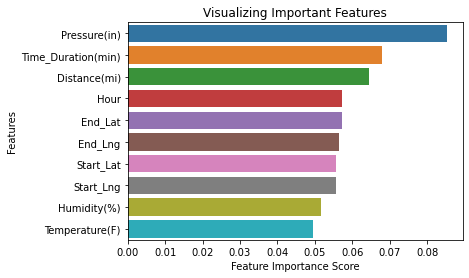

In [260]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [261]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

Pressure(in)               0.085197
Time_Duration(min)         0.067827
Distance(mi)               0.064533
Hour                       0.057224
End_Lat                    0.057217
End_Lng                    0.056515
Start_Lat                  0.055712
Start_Lng                  0.055578
Humidity(%)                0.051593
Temperature(F)             0.049413
Day                        0.044592
Visibility(mi)             0.019867
Weather_Condition_Clear    0.018200
Wind_Direction_Calm        0.015743
Sunrise_Sunset_Night       0.012292
Weekday_Sun                0.010719
Weekday_Sat                0.009967
Junction                   0.008948
Weekday_Thu                0.008860
Weekday_Tue                0.008068
dtype: float64

Select the top important features, set the threshold

In [262]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.05
sfm = SelectFromModel(clf, threshold=0.05)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Start_Lng
Start_Lat
End_Lng
End_Lat
Distance(mi)
Humidity(%)
Pressure(in)
Hour
Time_Duration(min)


In [263]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [264]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Randon forest algorithm -- Full feature] accuracy_score: 0.969.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.968.
